# 丢弃法

理论上优于权重衰退

**动机**

- 好的模型应该对输入扰动鲁棒
    - 有噪音的数据，相当于`Tikhonov`正则，使得权重不要太大
    - 丢弃法：在层间加入噪音

******

**无偏差的加入噪声**

希望：$E[x'] = x$

$$x_i' = \begin{cases}0 & \text{with probability} p\\\frac{x_i}{1-p}&otherwise\end{cases}$$

******

**使用丢弃法**

- 通常作用在隐藏全连接层的输出上

$$
\begin{cases}
h=\sigma{W_1x+b_1} \\
h`= \text{dropout}(h) \\
o = W_2h`+b_2 \\
y = \text{softmax}(o)
\end{cases}
$$

> 训练中使用$dropout$，推理中不使用$dropout$

- 用于将隐藏层输出项随机设置为0来控制模型的复杂度
- 用于多层感知机(卷积神经网络一般不适用)**全连接层**
- 丢弃的概率是超参数

**神经网络的trick**

- 将模型容量设定的大一点，使用dropout
    - Eg. 64的隐藏层ok，128 开 0.5 dropout

In [18]:
%matplotlib inline
import time
import os
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [19]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    elif dropout == 0:
        return X
    else:
        mask = torch.rand(X.shape) > float(dropout)
        # rand [0,1)的均匀分布，randn N(0, 1)分布
        # 这种写法对于 CPU GPU 均不是很好
        # 乘法优于选择
        # X[mask] = 0
        return mask * X / (1.0 - dropout)

x = torch.arange(1, 17, dtype=torch.float32).reshape((2, 8))
dropout_layer(x, 0.5) == 0

tensor([[ True,  True,  True,  True,  True,  True, False, False],
        [ True, False, False, False,  True, False, False,  True]])

In [20]:
# 两个隐藏层的感知机
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 512, 256
dropout1 , dropout2 = 0.2, 0.5

class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, is_training=True):
        super().__init__()
        self.num_inputs = num_inputs
        self.training = is_training # 需要 is_training 判断是否 dropout

        self.lin1 = torch.nn.Linear(num_inputs, num_hidden1)
        self.lin2 = torch.nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = torch.nn.Linear(num_hidden2, num_outputs)

        self.relu = torch.nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training:
            H1 = dropout_layer(H1, dropout=dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout=dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs=num_inputs, num_outputs=num_outputs, num_hidden1=num_hidden1, num_hidden2=num_hidden2)

In [21]:
resize = None
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.ToTensor()
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

In [22]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

""" 评估 net 的准确性 """
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 如果是 torch 神经网络，则设置为评估模式，不进行反向传播
    accum = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            accum.add(accuracy(net(X), y), y.numel())
    return accum[0] / accum[1]

""" 一轮训练 """
def train_epoch_ch3(net, train_iter, loss, params, updater, lr):
    if isinstance(net, torch.nn.Module):
        net.train() # 训练模式，进行反向传播
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(params, lr, len(X)) # 更新器需要 batch_size
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
""" 训练函数 """

def train_ch3(net, train_iter, test_iter, loss, num_epochs, params, updater, lr):
    accumulator = [Accumulator(3) for _ in range(num_epochs)]
    for epoch in range(num_epochs):
        start = time.perf_counter()
        train_metrics = train_epoch_ch3(net, train_iter, loss, params, updater, lr) # 训练误差
        test_accuracy = evaluate_accuracy(net, test_iter) # 测试误差
        accumulator[epoch].add(train_metrics[0], train_metrics[1], test_accuracy)
        end = time.perf_counter()
        print(f"Finish {epoch + 1} train, cose {end-start:.3f} sec")
    return accumulator

In [23]:
lr = 0.05
num_epochs=50
loss = torch.nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
accumulator = train_ch3(net, train_iter, test_iter, loss, num_epochs, None, trainer, None)

Finish 1 train, cose 14.720 sec
Finish 2 train, cose 16.774 sec
Finish 3 train, cose 18.194 sec
Finish 4 train, cose 16.798 sec
Finish 5 train, cose 18.925 sec
Finish 6 train, cose 19.237 sec
Finish 7 train, cose 20.446 sec
Finish 8 train, cose 20.369 sec
Finish 9 train, cose 14.668 sec
Finish 10 train, cose 13.760 sec
Finish 11 train, cose 12.295 sec
Finish 12 train, cose 12.126 sec
Finish 13 train, cose 12.162 sec
Finish 14 train, cose 13.772 sec
Finish 15 train, cose 12.536 sec
Finish 16 train, cose 12.285 sec
Finish 17 train, cose 13.990 sec
Finish 18 train, cose 14.076 sec
Finish 19 train, cose 12.269 sec
Finish 20 train, cose 11.973 sec
Finish 21 train, cose 12.086 sec
Finish 22 train, cose 12.107 sec
Finish 23 train, cose 14.230 sec
Finish 24 train, cose 12.817 sec
Finish 25 train, cose 12.162 sec
Finish 26 train, cose 12.092 sec
Finish 27 train, cose 12.406 sec
Finish 28 train, cose 12.222 sec
Finish 29 train, cose 12.090 sec
Finish 30 train, cose 12.224 sec
Finish 31 train, co

Test accuracy : 0.888


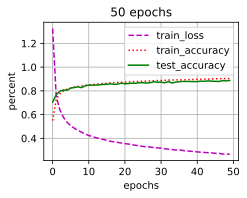

In [24]:
""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

""" 绘图 """
backend_inline.set_matplotlib_formats('svg')
plt.rcParams["figure.figsize"] = (3.5, 2.5)

train_loss, train_accuracy, test_accuracy = [], [], []
for i in range(num_epochs):
    train_loss.append(accumulator[i][0])
    train_accuracy.append(accumulator[i][1])
    test_accuracy.append(accumulator[i][2])
    
plt.plot(list(range(num_epochs)), train_loss, 'm--')
plt.plot(list(range(num_epochs)), train_accuracy, 'r:')
plt.plot(list(range(num_epochs)), test_accuracy, 'g-')
plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
plt.xlabel('epochs')
plt.ylabel('percent')
plt.title(f'{num_epochs} epochs')
plt.grid(True)

print(f"Test accuracy : {test_accuracy[-1]:.3f}")

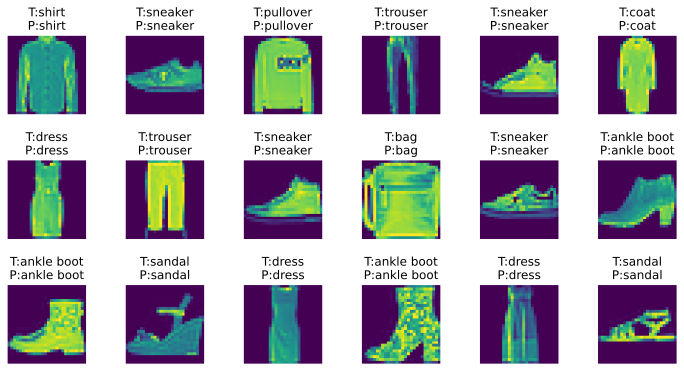

In [25]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
    
def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    show_img(X[0:n].reshape([n, 28, 28]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

# QA

- 丢弃的项，导数也为0
- dropout的可重复性？可以通过固定随机数种子，保证dropout可重复性
- 由于浮点数没有结合性，cuDNN每次并行计算，浮点数的计算顺序不同，计算有可能返回不同值
    - $(a+b)+c \neq a+(b+c)$
- 随机性能保证鲁棒性
- dropout 会导致收敛变慢
